In [6]:
import os
from termcolor import colored
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

RUN_OPTIONAL_CELLS = True

In [7]:
train = pd.read_csv('data/train.csv')
DROP = ['url', 'user_id']

# Image Data

In [8]:
IMG_SHAPE = (600, 600, 3)
IMG_SOURCE = ['external', 'native'] # native, external, external_2

import cv2
print(f'{colored("Memory Needed", "red")} Minimum : {colored(IMG_SHAPE[0]*IMG_SHAPE[1]*IMG_SHAPE[2]*len(train)*len(os.listdir("./data/external/"))*len(os.listdir("./data/external_2/"))//1028//1028, "green")} MB')

Memory Needed Minimum : 8338031393 MB


In [9]:
def to_numpy_arr(file_path:str):
    if file_path.endswith('.csv'):
        data = pd.read_csv(file_path)
        img_arr = None
        for inx, row in tqdm(data.iterrows(), total=len(data)):
            nw_img_path = row['media']
            if img_arr is None:
                img_arr = cv2.resize(cv2.cvtColor(cv2.imread(f'data/media/{nw_img_path}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)
            else:
                img_arr = np.vstack([img_arr, cv2.resize(cv2.cvtColor(cv2.imread(f'data/media/{nw_img_path}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)])
        return img_arr, data['label']
    else:
        img_arr = None
        for current_file in os.listdir(file_path):
            if not current_file.endswith('.jpg'):
                continue
            nw_img_path = os.path.join(file_path, current_file)
            if img_arr is None:
                img_arr = cv2.resize(cv2.cvtColor(cv2.imread(f'data/media/{nw_img_path}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)
            else:
                img_arr = np.vstack([img_arr, cv2.resize(cv2.cvtColor(cv2.imread(f'data/media/{nw_img_path}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)])
        return img_arr

## Internal Data

In [10]:
if 'native' in IMG_SOURCE:
    file_name = f'checkpoints/img_arr_{IMG_SHAPE}'
    if os.path.exists(file_name+'.npy'):
        img_arr, target = np.load(file_name+'.npy')
    else:
        img_arr, target = to_numpy_arr('data/train.csv')
        np.save(file_name, img_arr)

ValueError: too many values to unpack (expected 2)

## External Data

In [ ]:
pass
if 'external' in IMG_SOURCE:
    pass

## Image Checking

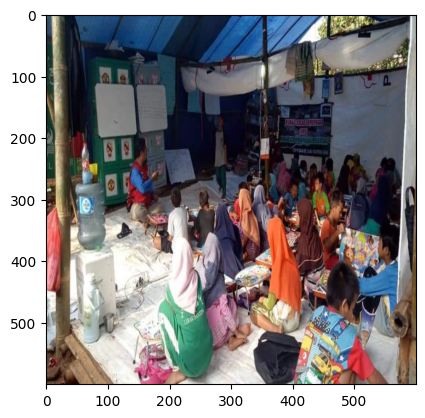

In [ ]:
if RUN_OPTIONAL_CELLS:
    import random
    index = random.randint(0, len(img_arr))
    plt.imshow(img_arr[index])

## Image Augmentation

In [ ]:
pass

# Modelling

In [ ]:
import tensorflow as tf
import keras
from keras import layers, activations, losses, optimizers, initializers, regularizers, metrics, Input

## EfficientNetB7

In [ ]:
from keras.applications import EfficientNetB7
# from keras.applications.EfficientNetB7 import preprocess_input

input_layer = Input(shape=IMG_SHAPE, dtype=tf.int32)
efficientNetB7_layer = EfficientNetB7()(input_layer)
flatten_layer = layers.Flatten()(efficientNetB7_layer)
dense_layer = layers.Dense(100, activation='relu')(flatten_layer)
dropout_layer = layers.Dropout(.2)(dense_layer)
output_layer = layers.Dense(1, activation='sigmoid')(dropout_layer)

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile('adam', loss=losses.BinaryCrossentropy(), metrics=[metrics.mae, metrics.accuracy])

In [ ]:
model.fit(img_arr, target, batch_size=32, epochs=200)

Epoch 1/200


ValueError: in user code:

    File "C:\Users\Eryawan\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Eryawan\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Eryawan\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Eryawan\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Eryawan\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Eryawan\AppData\Roaming\Python\Python310\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model" "                 f"(type Functional).
    
    Input 0 of layer "efficientnetb7" is incompatible with the layer: expected shape=(None, 600, 600, 3), found shape=(None, 800, 800, 3)
    
    Call arguments received by layer "model" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None, 800, 800, 3), dtype=uint8)
      • training=True
      • mask=None
